<a href="https://colab.research.google.com/github/hansbrunner/epidemiology-analysis/blob/main/cancer_prediction_from_age_sex_smokinghistory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
"""
NHANES dataset
I conducted a simple analysis to investigate the relationship between cancer status and three key features: age, sex, and smoking history.
My approach involved both individual feature analysis and a machine learning model to assess their combined predictive power.

Individual Feature Analysis:


Smoking history: I used a simplified smoking variable, defined as whether an individual had smoked more than 100 cigarettes in their lifetime.
While there was some relationship between smoking and cancer, it wasn’t as strong as anticipated.

Age: I found that age was strongly related to cancer status.
As expected, older individuals had a higher likelihood of reporting a cancer diagnosis.

Sex: I also explored the association between sex and cancer, but no significant relationship was observed when sex was analyzed independently.

Random Forest Classifier: To assess the combined influence of all features, I trained a Random Forest classifier to predict cancer status using age, sex, and smoking history.
The model showed that age was by far the most important predictor of cancer status. The importance of smoking history was relatively low in this model.

One potential reason smoking didn’t emerge as the primary predictor is the way smoking was defined in the dataset.
I used a simple measure of smoking history (i.e., whether the person had smoked more than 100 cigarettes in their lifetime).
This definition doesn’t account for the intensity and duration of smoking,
which are better captured by measures like pack-years (the number of years a person smoked one pack per day).
It’s possible that using a more detailed measure of smoking exposure would better reflect the relationship between smoking and cancer.
"""

'\nNHANES dataset\nI conducted a simple analysis to investigate the relationship between cancer status and three key features: age, sex, and smoking history.\nMy approach involved both individual feature analysis and a machine learning model to assess their combined predictive power.\n\nIndividual Feature Analysis:\n\n\nSmoking history: I used a simplified smoking variable, defined as whether an individual had smoked more than 100 cigarettes in their lifetime.\nWhile there was some relationship between smoking and cancer, it wasn’t as strong as anticipated.\n\nAge: I found that age was strongly related to cancer status. \nAs expected, older individuals had a higher likelihood of reporting a cancer diagnosis.\n\nSex: I also explored the association between sex and cancer, but no significant relationship was observed when sex was analyzed independently.\n\nRandom Forest Classifier: To assess the combined influence of all features, I trained a Random Forest classifier to predict cancer st

In [6]:
from google.colab import drive
import pandas as pd
import urllib.request

# Function to fetch and read XPT-files
def fetch_xpt_data(url, filename):
    urllib.request.urlretrieve(url, filename)  # Fetch XPT-file from URL
    data = pd.read_sas(filename)  # Read XPT-file to pandas DataFrame
    return data

# Get data
urls = {
    "demographics": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DEMO.XPT",  # Demographics
    "medical_conditions": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_MCQ.XPT",  # Medical conditions
    "smoking": "https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_SMQ.XPT" # Smoking questionnaire
}

demographics_data = fetch_xpt_data(urls["demographics"], "demographics.xpt")
medical_conditions_data = fetch_xpt_data(urls["medical_conditions"], "medical_conditions.xpt")
smoking_data = fetch_xpt_data(urls["smoking"], "smoking.xpt")

# Select data from each dataset
demographics_relevant = demographics_data[['SEQN', 'RIAGENDR', 'RIDAGEYR']]  # Sex and age
medical_conditions_relevant = medical_conditions_data[['SEQN', 'MCQ220']]  # Lung cancer
smoking = smoking_data[['SEQN', 'SMQ020', 'SMQ040']]  # SMQ020 = Smoked more than 100 cigarettes, SMQ040 = Current smoker

# Merge datasets based on ID (SEQN)
df = pd.merge(demographics_relevant, medical_conditions_relevant, on='SEQN')
df = pd.merge(df, smoking, on='SEQN')

In [7]:
"""
Relationship between smoking history and cancer
Nullhypothesis (H0): No relationship between smoking and cancer
Alternative hypothesis (H1): Smoking is associated with increased risk of developing cancer
"""
from scipy.stats import chi2_contingency
# remove incomplete data
filtered_data = df[
    df['MCQ220'].isin([1, 2]) & df['SMQ020'].isin([1, 2])
]
# Odds ratio
table = pd.crosstab(filtered_data['SMQ020'], filtered_data['MCQ220'], rownames=['Smoking'], colnames=['Cancer'])
a = table.iloc[0, 0]  # Smokers with cancer
b = table.iloc[1, 0]  # Non-smokers with cancer
c = table.iloc[0, 1]  # Smokers without cancer
d = table.iloc[1, 1]  # Non-smokers without cancer
odds_ratio = (a / c) / (b / d)
print(f'Odds Ratio: {odds_ratio}')

chi2, p, dof, expected = chi2_contingency(table)
print(f'Chi²: {chi2}, p-value: {p}')

Odds Ratio: 1.4409238951980052
Chi²: 29.620250191128388, p-value: 5.2553034220032655e-08


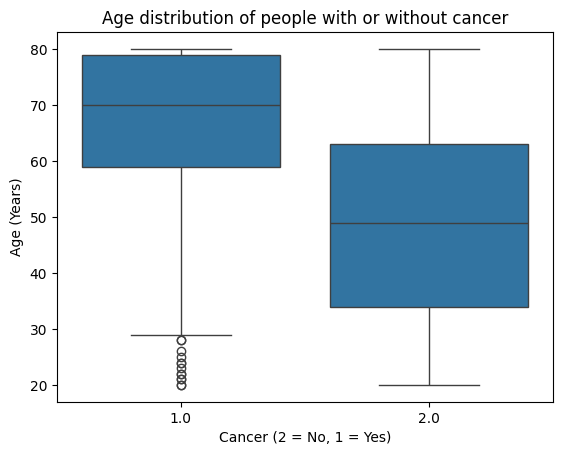

T-stat: 36.644011675351265, p-value: 3.827353824922563e-208


In [8]:
"""
Relationship between age and cancer
Nullhypothesis (H0): No relationship between age and cancer
Alternativ hypotese (H1): Elder people have increased risk of cancer
"""
from scipy.stats import ttest_ind
# remove incomplete data
filtered_data = df[df['MCQ220'].isin([1, 2])]

# visualize age distribution with box plots
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot of age and cancer status
sns.boxplot(x='MCQ220', y='RIDAGEYR', data=filtered_data)
plt.xlabel("Cancer (2 = No, 1 = Yes)")
plt.ylabel("Age (Years)")
plt.title("Age distribution of people with or without cancer")
plt.show()

# Average age for cancer and none cancer group
cancer_group = filtered_data[filtered_data['MCQ220'] == 1]['RIDAGEYR']
no_cancer_group = filtered_data[filtered_data['MCQ220'] == 2]['RIDAGEYR']

# T-test to see if there is a significant difference between age
t_stat, p_val = ttest_ind(cancer_group, no_cancer_group, equal_var=False)
print(f'T-stat: {t_stat}, p-value: {p_val}')

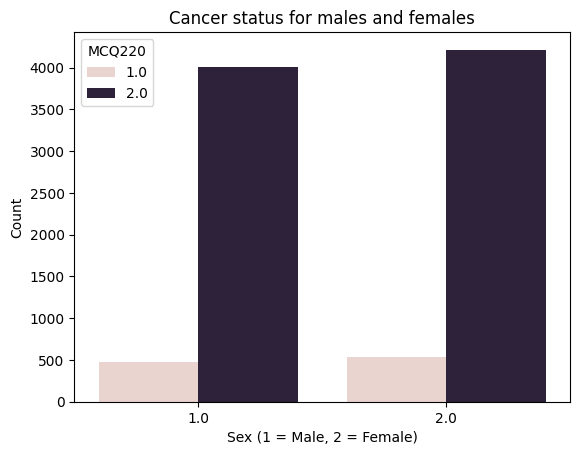

Odds Ratio: 0.921934116840945
Chi²: 1.3951805150335834, p-value: 0.23753217915574032


In [9]:
"""
Relationship between sex and cancer
Nullhypothesis (H0): No relationship between sex and cancer
Alternative hypothesis (H1): Relationship between sex and cancer
"""
# remove incomplete data
filtered_data = df[
    df['MCQ220'].isin([1, 2]) & df['RIAGENDR'].isin([1, 2])
]
# plot distribution of cancer between sexes
sns.countplot(x='RIAGENDR', hue='MCQ220', data=filtered_data)
plt.xlabel("Sex (1 = Male, 2 = Female)")
plt.ylabel("Count")
plt.title("Cancer status for males and females")
plt.show()

# Odds ratio
table = pd.crosstab(filtered_data['RIAGENDR'], filtered_data['MCQ220'], rownames=['Sex'], colnames=['Cancer'])
a = table.iloc[0, 0]  # Males with cancer
b = table.iloc[1, 0]  # Females with cancer
c = table.iloc[0, 1]  # Males without cancer
d = table.iloc[1, 1]  # Females without cancer

odds_ratio = (a / c) / (b / d)
print(f'Odds Ratio: {odds_ratio}')

chi2, p, dof, expected = chi2_contingency(table)
print(f'Chi²: {chi2}, p-value: {p}')

In [10]:
"""
Preprocess data for model
"""
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
# Clean data
cleaned_data = df.dropna(subset=['SMQ020', 'RIAGENDR', 'RIDAGEYR', 'MCQ220'])
filtered_data = cleaned_data.copy()
# 1 and 2 are legit answers to smoking history and cancer
filtered_data = filtered_data[
    (filtered_data['SMQ020'].isin([1, 2])) &
    (filtered_data['MCQ220'].isin([1, 2]))
]
# preprocess
filtered_data['Smoking'] = filtered_data['SMQ020'].apply(lambda x: 1 if x == 1 else 0) # 1 for yes, 0 for no
filtered_data['Female'] = filtered_data['RIAGENDR'].apply(lambda x: 1 if x == 2 else 0) # 1 for yes, 0 for no
filtered_data['Cancer'] = filtered_data['MCQ220'].apply(lambda x: 1 if x == 1 else 0) # 1 for yes, 0 for no

# normalize age
min_age = filtered_data['RIDAGEYR'].min()
max_age = filtered_data['RIDAGEYR'].max()
filtered_data['Normalized_Age'] = (filtered_data['RIDAGEYR'] - min_age) / (max_age - min_age)

X = filtered_data[['Smoking', 'Female', 'Normalized_Age']]
X = sm.add_constant(X) # add intercept
y = filtered_data['Cancer']

<ipython-input-15-c822fceb0d51>:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = res.anova_table['Pr > F'][0]


                Anova
       F Value  Num DF  Den DF  Pr > F
--------------------------------------
model 1344.9569 4.0000 116.0000 0.0000

ANOVA p-value: 0.0000
There are significant differences between the models.
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
   group1             group2         meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------
  Full Model              Null Model   -0.259    0.0 -0.2726 -0.2453   True
  Full Model            Shuffled Age  -0.2261    0.0 -0.2398 -0.2125   True
  Full Model            Shuffled Sex  -0.0117 0.1297 -0.0253  0.0019  False
  Full Model Shuffled Smoking Status  -0.0049 0.8576 -0.0185  0.0087  False
  Null Model            Shuffled Age   0.0328    0.0  0.0192  0.0465   True
  Null Model            Shuffled Sex   0.2473    0.0  0.2336  0.2609   True
  Null Model Shuffled Smoking Status   0.2541    0.0  0.2404  0.2677   True
Shuffled Age            

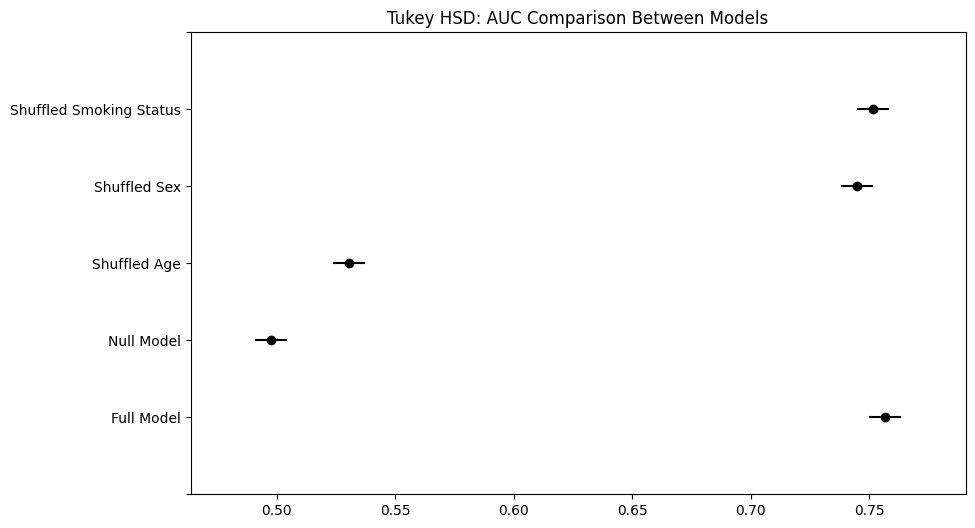

In [15]:
"""
Understanding Feature Importance and Model Performance Using Random Forest Classifier
In this analysis, I use a Random Forest classifier to predict cancer status.
First, I evaluate the performance of a full model using all features (age, smoking history, and sex). Then, I compare this to reduced models,
where I shuffle individual features (age, smoking history, and sex) to see how much the model's performance (measured by AUC) is affected.
Additionally, I include a null model, where the target variable (cancer) is shuffled to simulate random guessing.
By repeating this process multiple times, I use ANOVA to test whether the differences in AUC between models are statistically significant,
helping identifying the importance of each feature.
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Repeat the modeling process for a number of iterations
n_repeats = 30

# List to store results (AUC values and model types)
results = []

# Function to run models and return AUC
def run_models(X_train, X_test, y_train, y_test, model_name, n, shuffle_feature=None):
    X_train_copy = X_train.copy()

    # If shuffle_feature is not None, shuffle the specified feature
    if shuffle_feature:
        X_train_copy[shuffle_feature] = np.random.permutation(X_train_copy[shuffle_feature])

    # Train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
    rf_model.fit(X_train_copy, y_train)

    # Calculate AUC on the test set
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    # Append the results to our list
    results.append({'model': model_name, 'AUC': auc, 'subject': n,})

# Repeat the modeling process for each model for n_repeats times
for _ in range(n_repeats):
    #print(_)
    # Split the data into train and test sets for each iteration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None, stratify=y)

    # Full Random Forest model
    run_models(X_train, X_test, y_train, y_test, "Full Model", _)

    # Null model (shuffled y)
    y_train_shuffled = np.random.permutation(y_train)
    run_models(X_train, X_test, y_train_shuffled, y_test, "Null Model", _)

    # Shuffled Age
    run_models(X_train, X_test, y_train, y_test, "Shuffled Age", _, shuffle_feature='Normalized_Age')

    # Shuffled smoking status
    run_models(X_train, X_test, y_train, y_test, "Shuffled Smoking Status", _, shuffle_feature='Smoking')

    # Shuffled sex
    run_models(X_train, X_test, y_train, y_test, "Shuffled Sex", _, shuffle_feature='Female')

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Perform ANOVA test
aovrm = AnovaRM(results_df, 'AUC', 'subject', within=['model'])
res = aovrm.fit()
p_value = res.anova_table['Pr > F'][0]
print(res)

# Print the ANOVA results
print(f"ANOVA p-value: {p_value:.4f}")
if p_value < 0.05:
    print("There are significant differences between the models.")
else:
    print("There are no significant differences between the models.")

# Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=results_df['AUC'],      # AUC values
                          groups=results_df['model'],   # Model types (full, null, shuffled)
                          alpha=0.05)                   # Significance level

# Print the results
print(tukey)

# Plot the results for better visualization
tukey.plot_simultaneous()
plt.title('Tukey HSD: AUC Comparison Between Models')
plt.show()

